In [2]:
#Traditional Motion Detection Techniques

This project involves developing a motion detection system to identify abnormalities in video footage. The model  leverages various computer vision techniques to detect and analyze motion, focusing on efficiency and accuracy.

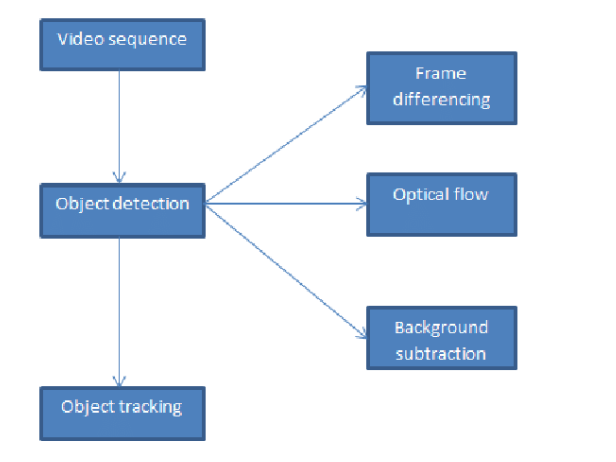

Architecture Overview

OpenCV's VideoCapture:

Purpose: Video Processing-To read video frames from a file.
Advantage: Efficiently handles various video formats and provides easy frame-by-frame access.

Frame Resizing: 

Technique: Resize the frame to a smaller size.
Why Chosen: Reducing the frame size decreases the number of pixels to process, speeding up computations.
Advantages: Faster processing with minimal loss of relevant detail.

Grayscale Conversion:

Technique: Convert frames to grayscale 
Why Chosen: Motion detection is based on intensity changes, which are easier to detect in grayscale.
Advantages: Reduces the complexity of the data, simplify the difference calculation making processing faster.

Performance Optimization:

Frame Skipping:
Technique: Skip frames to reduce processing load
Why Chosen: Processing every frame in a high-FPS video can be computationally expensive.
Advantages: Reduces computational load and speeds up processing while still capturing significant events.

Thread Pool: 

Technique: Use a thread pool to parallelize frame processing.
Why Chosen: .Utilizes multiple threads to process frames in parallel,Speed up the processing by taking advantage of multiple CPU cores.
Advantages: Improves the performance and efficiency of the system, speeding up the overall processing

Frame Processing-Motion Detection:

Frame Differencing: The difference between consecutive frames is calculated to detect motion.
Thresholding: The frame difference is thresholded to create a binary image highlighting regions with significant changes.
Contour Detection: Contours are found in the thresholded image to detect potential abnormalities.
Abnormality Detection: If significant contours are detected, the frame is marked as containing an abnormality.
Abnormality Handling:
Grouping and Timing: Abnormalities are grouped based on time gaps to avoid multiple detections of the same event.
Saving Frames: Frames containing abnormalities are saved for further analysis.

Abnormality start and end times, duration, and total video time:
Frame Number Calculation:
The frame number is incremented as frames are processed or skipped in the video.
Timestamp Calculation:
The timestamp of an abnormality is determined by dividing the frame number by the original FPS of the video. This converts the frame number to a time in seconds.


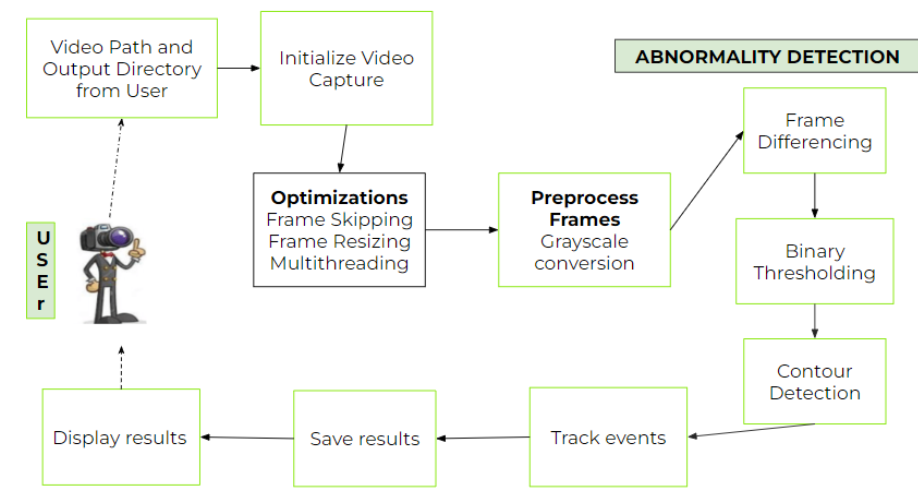

In [1]:
import cv2
import numpy as np
import os

In [3]:
def motion_detection(video_path, output_dir, threshold_value=25, min_contour_area=500, resize_factor=0.5, minimal_fps=5, min_abnormality_gap_minutes=1):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(original_fps / minimal_fps))

    ret, prev_frame = cap.read()
    if not ret:
        print("Error reading the first frame")
        return

    prev_frame = cv2.resize(prev_frame, (0, 0), fx=resize_factor, fy=resize_factor)
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    abnormality_times = []

    frame_number = 0
    abnormality_detected = False
    abnormality_start_frame = None
    abnormality_group_id = 0
    last_abnormality_time = None

    os.makedirs(output_dir, exist_ok=True)

    while True:
        for _ in range(frame_skip_interval):
            ret, frame = cap.read()
            if not ret:
                break
            frame_number += 1

        if not ret:
            break

        frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
        frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
        frame_diff = cv2.absdiff(prev_frame_gray, frame_gray)
        _, thresh = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detected = any(cv2.contourArea(contour) > min_contour_area for contour in contours)

        if detected:
            current_abnormality_time = frame_number / original_fps

            if not abnormality_detected:
                if last_abnormality_time is None or (current_abnormality_time - last_abnormality_time) >= (min_abnormality_gap_minutes * 60):
                    abnormality_group_id += 1
                    os.makedirs(os.path.join(output_dir, f"abnormality_{abnormality_group_id}"))

                abnormality_start_frame = frame_number
                abnormality_detected = True
                abnormality_times.append(frame_number)
                last_abnormality_time = current_abnormality_time

            output_frame_path = os.path.join(output_dir, f"abnormality_{abnormality_group_id}", f"frame_{frame_number}.jpg")
            cv2.imwrite(output_frame_path, frame_resized)
        else:
            if abnormality_detected:
                abnormality_detected = False
                abnormality_end_frame = frame_number
                abnormality_start_seconds = abnormality_start_frame / original_fps
                abnormality_end_seconds = abnormality_end_frame / original_fps
                abnormality_duration_seconds = abnormality_end_seconds - abnormality_start_seconds

                print(f"Abnormality {abnormality_group_id} start time: {int(abnormality_start_seconds // 60)} minutes {abnormality_start_seconds % 60:.2f} seconds")
                print(f"Abnormality {abnormality_group_id} duration: {int(abnormality_duration_seconds // 60)} minutes {abnormality_duration_seconds % 60:.2f} seconds")

        prev_frame_gray = frame_gray

    cap.release()

    total_time_seconds = frame_number / original_fps
    print(f"Total video time: {int(total_time_seconds // 60)} minutes {total_time_seconds % 60:.2f} seconds")

    return abnormality_times

# Example usage
video_path = r"C:\Users\pkathi\Desktop\my work\computervision-video\cvcodecheck\inputvideo.mp4"
output_dir = 'C:/Users/pkathi/Desktop/my work/computervision-video/cvcodecheck/testcode'
abnormality_times = motion_detection(video_path, output_dir, minimal_fps=5)

if abnormality_times:
    print("Abnormality detected at frame numbers:", abnormality_times)
else:
    print("No abnormality detected in the video.")


Abnormality 1 start time: 0 minutes 45.00 seconds
Abnormality 1 duration: 0 minutes 12.00 seconds
Abnormality 1 start time: 0 minutes 57.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 0 minutes 57.80 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 0 minutes 58.20 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Total video time: 0 minutes 60.00 seconds
Abnormality detected at frame numbers: [1350, 1722, 1734, 1746, 1758]
